# Extreme-Correction applied to Hs and Tp

Extreme correction technique applied to Hs and Tp from Santoña.

In [68]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

os.chdir(r"c:\Users\user\Victor\Trabajo\ExtremeCorrection")
from src.extr_corr import ExtremeCorrection

# Load Data

In [69]:
historical_dataset = xr.open_dataset("Data/DatosJared/Wave_families_santona_daily.nc")
sampled_dataset = xr.open_dataset("Data/DatosJared/simulated_waves.nc").rename({"bulk_Hs": "Hs", "bulk_Tp": "Tp", "bulk_Dir": "Dir"})

In [70]:
historical_dataset

<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    bmus         (time) int64 ...

In [71]:
sampled_dataset

<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 36891)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT      (n_sim, time) int64 ...
    Hs       (n_sim, time) float64 ...
    Tp       (n_sim, time) float64 ...
    Dir      (n_sim, time) float64 ...

Asumo que bmus tiene los WT, sino habria que cogerlos de la siguiente forma:

In [72]:
df_hist = historical_dataset.to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_hist["yyyy"] = df_hist.index.year
df_hist["mm"] = df_hist.index.month
df_hist["dd"] = df_hist.index.day
df_hist = df_hist.reset_index()
df_hist["time"] = df_hist.index / 365.25
df_hist.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.023583,4.836266,185.625000,1979,1,1
1,0.002738,1.341333,5.067072,89.291664,1979,1,2
2,0.005476,1.855333,6.305674,126.416664,1979,1,3
3,0.008214,4.830250,11.519656,282.291656,1979,1,4
4,0.010951,2.902167,11.920074,305.916656,1979,1,5


In [73]:
df_sim = sampled_dataset.sel(n_sim=0).to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_sim["yyyy"] = df_sim.index.year
df_sim["mm"] = df_sim.index.month
df_sim["dd"] = df_sim.index.day
df_sim = df_sim.reset_index()
df_sim["time"] = df_sim.index / 365.25
df_sim.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.750975,8.529534,283.245014,1999,1,1
1,0.002738,1.627966,8.854106,299.305291,1999,1,2
2,0.005476,2.761744,9.576388,329.714930,1999,1,3
3,0.008214,2.325261,14.954787,306.216905,1999,1,4
4,0.010951,1.819668,16.823529,288.421431,1999,1,5


In [74]:
df_sim["Hs"] = df_sim["Hs"] * 0.4  # Simulated data correction factor to increase the variable instead of reducing it

# Hs

Init threshold of quantile 0.98

In [75]:
np.quantile(df_hist["Hs"], 0.98)

5.4903304195404035

In case we want to use the minimum AM value of $H_s$ as init threshold

In [76]:
df_hist.groupby(["yyyy"])["Hs"].max().min()

5.910250186920166

In [77]:
config = {
    'var': "Hs",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/Santona/Hs_Santona_Hs_REVERSED',
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2,
    'init_threshold': np.quantile(df_hist["Hs"], 0.98),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config,
    pot_config=pot_config,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 4.7852909576150795


In [78]:
extr_corr_complete.opt_threshold

5.491500377655029

In [79]:
ecdf_hist_hs = ECDF(df_hist["Hs"])
ecdf_hist_hs(extr_corr_complete.opt_threshold)

0.9800136892539356

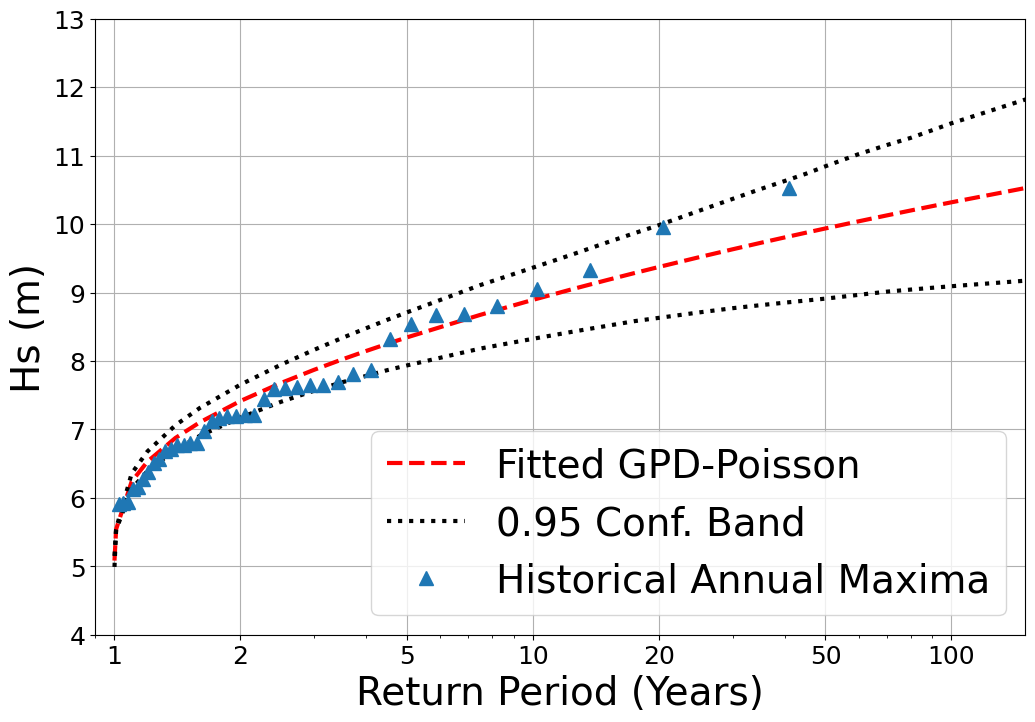

In [80]:
extr_corr_complete.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete.return_period_plot(conf_int_method="bootstrap")
ax.set_ylim(4, 13)
ax.set_xlim(0.9,150)
ax.set_ylabel("Hs (m)", fontsize=28)
ax.set_xlabel("Return Period (Years)", fontsize=28)
ax.legend(loc = "lower right", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

Threshold diagnostics

In [81]:
from scipy.signal import find_peaks
from scipy.stats import pearsonr

def pot_fun(
    data: np.ndarray,
    threshold: float = 0.0,
    n0: int = 10,
    min_peak_distance: int = 2,
    sig_level: float = 0.05,
):
    """
    Function to identiy POT
    This function identifies peaks in a dataset that exceed a specified
    threshold and computes statistics such as mean exceedances, variances,
    and weights for valid unique peaks. Peaks are considered independent if
    they are separated by a minimum distance.

    Parameters
    ----------
    data : np.ndarray(n,)
        Input time series or data array
    threshold : float, default=0
        Threshold above which peaks are extracted
    n0 : int, default=10
        Minimum number of exceedances required for valid computation
    min_peak_distance : int, default = 2
        Minimum distance between two peaks (in data points)
    sig_level : float, default=0.05
        Significance level for Chi-squared test

    Returns
    -------
    pks_unicos_valid : np.ndarray
        Valid unique peaks after removing NaN values
    excedencias_mean_valid : np.ndarray
        Mean exceedances for valid peaks
    excedencias_weight_valid : np.ndarray
        Weights based on exceedance variance for valid peaks
    pks : np.ndarray
        All detected peaks
    locs : np.ndarray
        Indices of the detected peaks in the data
    autocorrelations : np.ndarray(n, 3)
        Lags, correlations and pvalues to check the independence assumption
    """
    # Find peaks exceeding the threshold with specified min distance
    adjusted_data = np.maximum(data - threshold, 0)

    # Usamos la librería detecta que tiene el mismo funcionamiento que la función de matlab findpeaks
    locs, _ = find_peaks(adjusted_data, distance=min_peak_distance + 1)
    # Con scipy
    # locs, _ = find_peaks(adjusted_data, distance=min_peak_distance)

    pks = data[locs]

    # Calculate autocorrelation for lags 1 to 5 (if enough peaks)
    num_lags = 5
    if len(pks) > num_lags:
        autocorrelations = np.zeros((num_lags, 3), dtype=float)
        for i in range(num_lags):
            lag = i + 1
            r, p_value = pearsonr(pks[:-lag], pks[lag:])  # Test corr != 0
            autocorrelations[i, 0] = int(lag)
            autocorrelations[i, 1] = r
            autocorrelations[i, 2] = p_value

            if p_value < sig_level:
                Warning(
                    f"Lag {int(lag)} significant, consider increase the number of min_peak_distance"
                )
    else:
        # Not enough peaks for autocorrelation analysis
        autocorrelations = np.array([])

    # Unique peaks (pks_unicos), ignoring duplicates
    pks_unicos = np.unique(pks)

    # Allocate arrays to store mean exceedances, variances, and weights
    excedencias_mean = np.zeros(len(pks_unicos), dtype=float)
    excedencias_var = np.zeros(len(pks_unicos), dtype=float)
    excedencias_weight = np.zeros(len(pks_unicos), dtype=float)

    # Loop through each unique peak and calculate mean exceedances, variances, and weights
    for i in range(len(pks_unicos)):
        # Define the current unique peak
        pico_actual = pks_unicos[i]

        # Calculate the exceedances for peaks greater than the current unique peak
        excedencias = pks[pks > pico_actual]

        # If there are enough exceedances (greater than or equal to n0)
        if len(excedencias) >= n0:
            # Compute the mean exceedance (adjusted by the current peak)
            excedencias_mean[i] = np.mean(excedencias) - pico_actual
            # Compute the variance of the exceedances (ddof=1 to use the same variance as matlab)
            excedencias_var[i] = np.var(excedencias, ddof=1)
            # Compute the weight as the number of exceedances divided by the variance
            # Weight = number of exceedances / variance
            # (Guard against division by zero)
            if excedencias_var[i] != 0:
                excedencias_weight[i] = len(excedencias) / excedencias_var[i]
            else:
                excedencias_weight[i] = np.nan
        else:
            # If fewer than n0 exceedances, truncate arrays and stop
            excedencias_mean = excedencias_mean[:i]
            excedencias_var = excedencias_var[:i]
            excedencias_weight = excedencias_weight[:i]
            break

    # Trim the list of unique peaks to match the number of valid exceedances
    pks_unicos = pks_unicos[: len(excedencias_weight)]

    # Remove any NaN values from the peak and exceedance data to avoid issues in regression
    valid_indices = (
        ~np.isnan(pks_unicos)
        & ~np.isnan(excedencias_mean)
        & ~np.isnan(excedencias_weight)
    )
    pks_unicos_valid = pks_unicos[valid_indices]
    excedencias_mean_valid = excedencias_mean[valid_indices]
    excedencias_weight_valid = excedencias_weight[valid_indices]

    return (
        pks_unicos_valid,
        excedencias_mean_valid,
        excedencias_weight_valid,
        pks,
        locs,
        autocorrelations,
    )

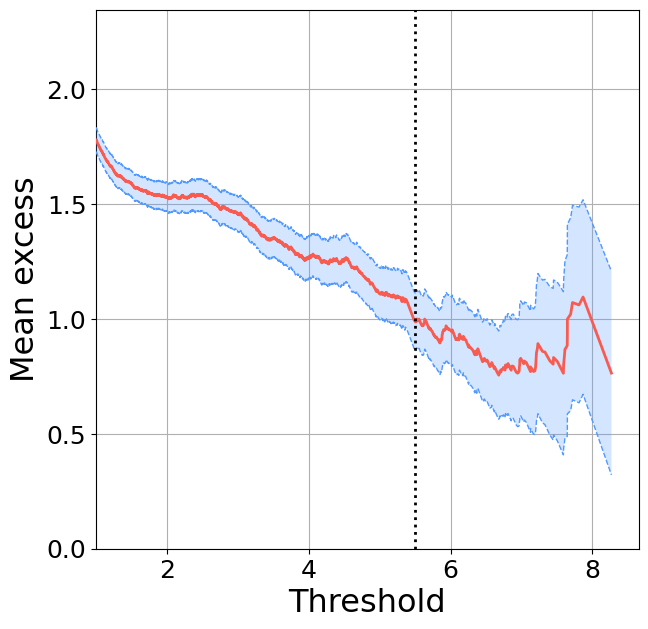

In [82]:
from scipy.stats import norm

mrlp_threshold = 0.0 
# mrlp_threshold = extr_corr_complete.opt_threshold

(
    pks_unicos_valid,
    excedencias_mean_valid,
    excedencias_weight_valid,
    pks,
    locs,
    autocorrelations,
) = pot_fun(df_hist["Hs"], mrlp_threshold)



# if conf_level is not None:
interlow, interup = norm.interval(
    0.95,
    loc=excedencias_mean_valid,
    scale=np.sqrt(1 / excedencias_weight_valid),
)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.grid(False)

# Plotting central estimates of mean re sidual life
ax.plot(
    pks_unicos_valid,
    excedencias_mean_valid,
    color="#F85C50",
    lw=2,
    ls="-",
    zorder=15,
)

# if conf_level is not None:
ax.plot(pks_unicos_valid, interlow, color="#5199FF", lw=1, ls="--", zorder=10)
ax.plot(pks_unicos_valid, interup, color="#5199FF", lw=1, ls="--", zorder=10)

ax.fill_between(
    pks_unicos_valid,
    interlow,
    interup,
    facecolor="#5199FF",
    edgecolor="None",
    alpha=0.25,
    zorder=5,
)

ax.vlines(extr_corr_complete.opt_threshold, ymin=0, ymax=excedencias_mean_valid.max()*1.1, colors="k", linestyles="dotted", lw=2, label="Optimal threshold", zorder=20)
ax.set_ylim(0, excedencias_mean_valid.max()*1.1)
ax.set_xlim(1)
ax.set_xlabel("Threshold", fontsize=23)
ax.set_ylabel("Mean excess", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_MRLP.png", dpi=300, bbox_inches="tight")
plt.show()

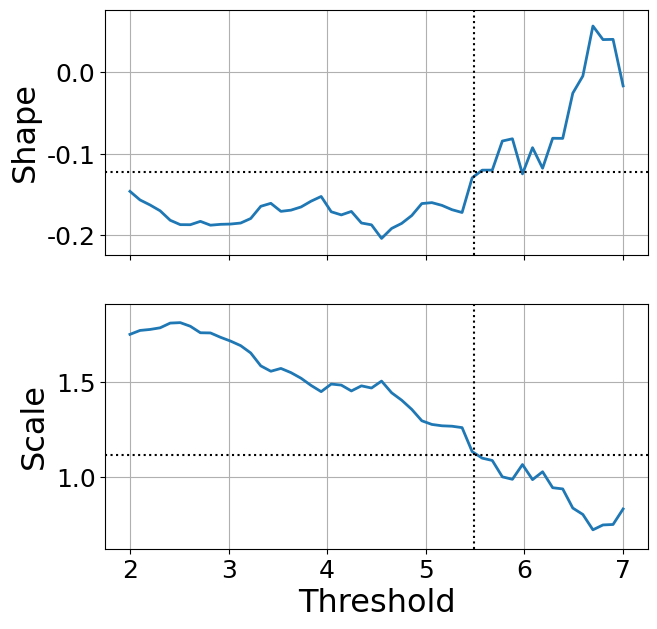

In [83]:
from scipy.stats import genpareto
thresholds = np.linspace(2, 7, 50)
shape_stab = []
scale_stab = []
for threshold in thresholds:
    pot, pot_sorted, locs = extr_corr_complete.obtain_pots(
        df_hist["Hs"], 
        n0=10, 
        min_peak_distance=2, 
        threshold=threshold,
        optimize_threshold=False
    )
    
    shape, _, scale = genpareto.fit(pot, floc=threshold)
    shape_stab.append(shape)
    scale_stab.append(scale)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(211)
ax1.plot(thresholds, shape_stab, lw=2)
ax1.vlines(extr_corr_complete.opt_threshold, ymin=min(shape_stab)-0.02, ymax=max(shape_stab)+0.02, color="k", ls="dotted", lw=1.5)
# ax1.set_xlabel("Threshold")
ax1.set_ylabel("Shape", fontsize=23)
ax1.axhline(y=extr_corr_complete.parameters[2], color="k", ls="dotted", lw=1.5)
ax1.grid()
ax1.set_ylim(min(shape_stab)-0.02, max(shape_stab)+0.02)
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

ax2 = fig.add_subplot(212)
ax2.plot(thresholds, scale_stab, lw=2)
ax2.vlines(extr_corr_complete.opt_threshold, ymin=min(scale_stab)-0.1, ymax=max(scale_stab)+0.1, color="k", ls="dotted", lw=1.5)
ax2.set_xlabel("Threshold", fontsize=23)
ax2.set_ylabel("Scale", fontsize=23)
ax2.axhline(y=extr_corr_complete.parameters[1], color="k", ls="dotted", lw=1.5)
ax2.grid()
ax2.set_ylim(min(scale_stab)-0.1, max(scale_stab)+0.1)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='minor', labelsize=18)
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_StabPlots.png", dpi=300, bbox_inches="tight")

plt.show()


In [84]:
extr_corr_complete.opt_threshold

5.491500377655029

In [85]:
extr_corr_complete.test_dist()

{'Statistic': 5.157517886892309, 'P-value': 8.543066254418363e-11}

In [86]:
def q_gev(prob, p):
    """
    Quantile function of GEV
    """
    xi = p[2]
    mu = p[0]
    sigma = p[1]

    if np.abs(xi) < 1e-8:
        return mu - sigma * np.log(-np.log(prob))
    else:
        return mu + (sigma/xi)*((-np.log(prob))**(-xi)-1)

In [87]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete.parameters
mu = u + sigma/xi * (extr_corr_complete.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

Bootstrap p-value of CvM test 0.0004997501249375312


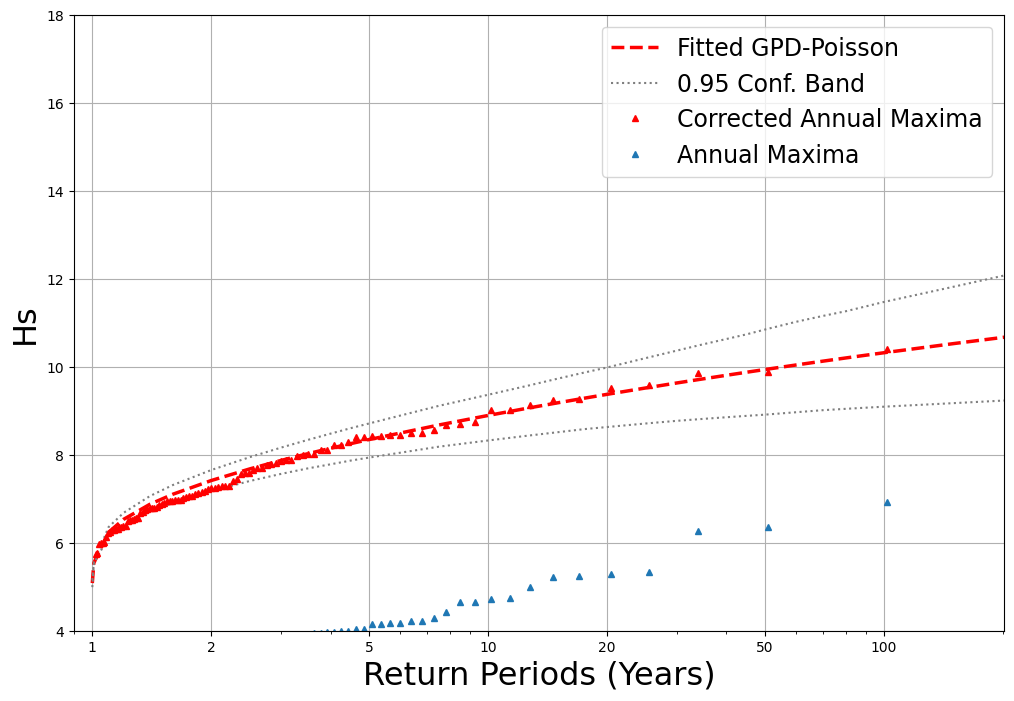

In [88]:
quantile_to_correct = 0.9
extr_corr_complete.apply_sim_correction(quantile_to_correct=quantile_to_correct)
fig, ax = extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(4, 18)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [89]:
extr_corr_complete.quantile_to_correct

0.9

In [90]:
extr_corr_complete.poiss_parameter

4.824894318959617

In [91]:
extr_corr_complete.time_interval_hist

40.000876131441615

In [92]:
extr_corr_complete.n_pit / 362.242

40.332153643144636

In [93]:
extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242)

4.78526392881588

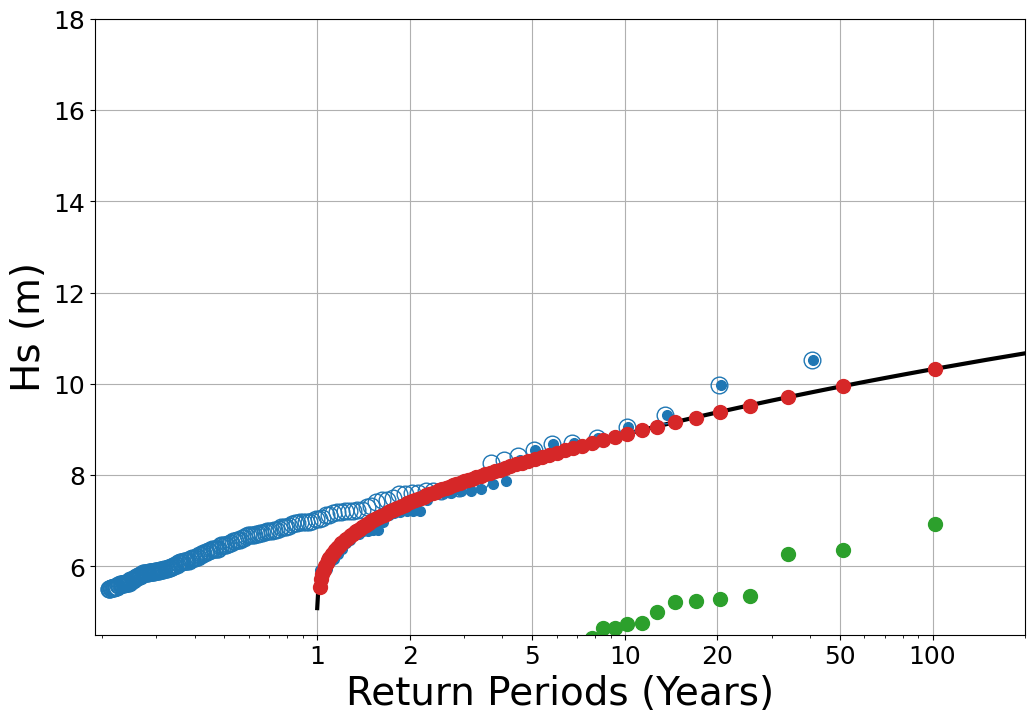

In [94]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, np.sort(extr_corr_complete.x_vals_gpd_poiss_hist), color = 'black', linewidth=3, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=7, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=12, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)
ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="tab:green", linewidth=0, marker='o',markersize=10, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete.n_pot_sim + 1) / (extr_corr_complete.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete.n_sim_year_peaks - extr_corr_complete.am_index_0)  # Corrected simulated AM data
ecdf_max_probs_sim = np.arange(1, extr_corr_complete.n_sim_year_peaks + 1 - extr_corr_complete.am_index_0) / (extr_corr_complete.n_sim_year_peaks + 1 - extr_corr_complete.am_index_0)   # ECDF
sim_max_data_corrected = q_pot(ecdf_max_probs_sim, extr_corr_complete.parameters, extr_corr_complete.poiss_parameter)    # Corrected POT
if extr_corr_complete.n_sim_year_peaks > 1:
    # sim_aux_pit_corrected = np.interp(
    #                 extr_corr_complete.sim_pit_data,              # x-coords to interpolate
    #                 np.append(min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted),    # x-coords of data points
    #                 np.append(min(extr_corr_complete.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
    #             )
    sim_aux_pit_corrected = np.interp(
                extr_corr_complete.sim_pit_data,              # x-coords to interpolate
                np.append([min(extr_corr_complete.sim_pit_data), np.quantile(extr_corr_complete.sim_pit_data, extr_corr_complete.quantile_to_correct)], extr_corr_complete.sim_max_data_sorted[extr_corr_complete.am_index_0:]),    # x-coords of data points
                np.append([min(extr_corr_complete.sim_pit_data), np.quantile(extr_corr_complete.sim_pit_data, extr_corr_complete.quantile_to_correct)], sim_max_data_corrected)  # y-coords of data points 
            )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_pit_data_corrected[extr_corr_complete.sim_max_idx])

ax.semilogx(extr_corr_complete.T_annmax_sim, sim_max_data_corrected_sorted, color = 'tab:red',linewidth=0, marker='o',markersize=10,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=28)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=28)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.19, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=4.5, top=18)
# ax.legend(loc='upper left', fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()

plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")
plt.show()

In [95]:
extr_corr_complete.parameters

[5.491500377655029, 1.1128642407260836, -0.12203866981894917]

In [96]:
extr_corr_complete.poiss_parameter, extr_corr_complete.sim_poiss_parameter

(4.824894318959617, 0.03960336134453782)

In [97]:
extr_corr_complete.sim_poiss_parameter/extr_corr_complete.poiss_parameter

0.008208130318816478

## Loop over correction

In [98]:
dict_maximos_corregidos_Hs = {}
dict_sim_pit_corrected_Hs = {}

for i in range(100):
    
    extr_corr_complete.apply_sim_correction(random_state=i, quantile_to_correct=quantile_to_correct)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
   
    dict_maximos_corregidos_Hs[i] = np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_max_idx])
    dict_sim_pit_corrected_Hs[i] = extr_corr_complete.sim_pit_data_corrected

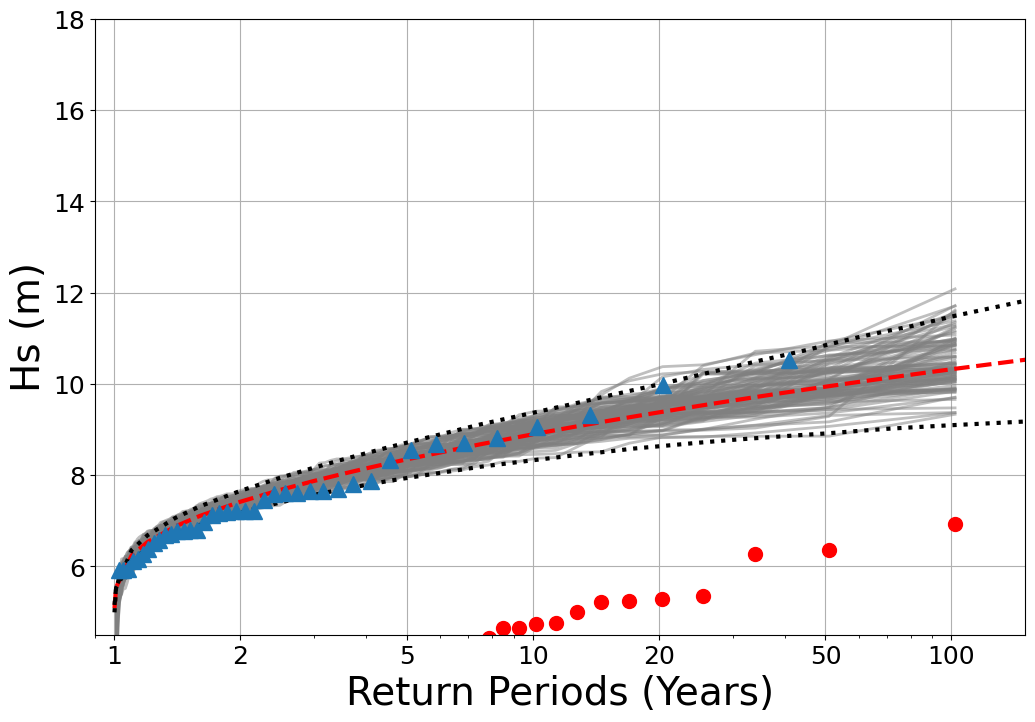

In [99]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.x_vals_gpd_poiss_sim, color = 'red',linestyle='dashed', linewidth=3, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=3, label=f'{extr_corr_complete.conf} Conf. Band')
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=3)


ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=10, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=12, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=28)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=28)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
# ax.set_xticklabels([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000], fontsize=15)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
# ax.set_yticklabels(ax.set, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=4.5, top=18)
# leg = ax.legend(loc='upper left', ncol=1, fontsize=23)
# for lh in leg.legend_handles:
#     lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [100]:
correlation_hs = extr_corr_complete.correlation()
correlation_hs

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9407117739312327}

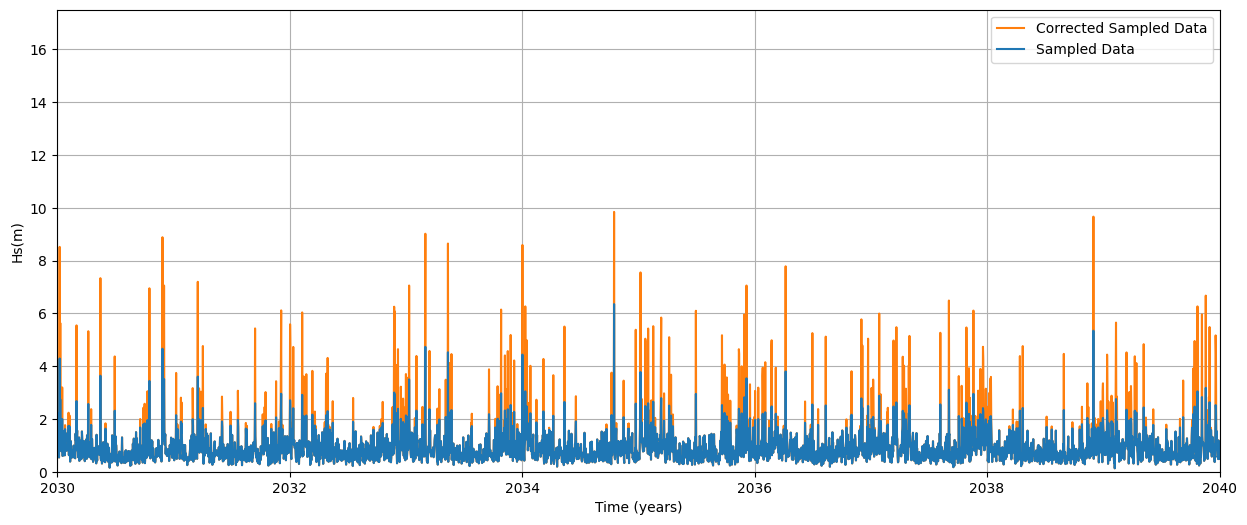

In [101]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data_corrected, label="Corrected Sampled Data", color="tab:orange")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data, label="Sampled Data", color="tab:blue")
# ax.hlines(5.25, xmin=2033, xmax=2035, color="black", linestyles="--")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 17.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hs(m)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change 

In [102]:
sim_poiss_param_100_hs = np.zeros(100)
for i in range(100):
    sim_pot_corrected_hs, _, _ = extr_corr_complete.obtain_pots(
                dict_sim_pit_corrected_Hs[i],
                threshold=extr_corr_complete.opt_threshold,
                n0 = extr_corr_complete.pot_config['n0'],
                min_peak_distance=extr_corr_complete.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete.pot_config['siglevel'],
                plot_flag = extr_corr_complete.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_hs[i] = sim_pot_corrected_hs.size / extr_corr_complete.time_interval_sim

In [103]:
print(np.median(sim_poiss_param_100_hs), np.mean(sim_poiss_param_100_hs), np.std(sim_poiss_param_100_hs))

4.207857142857143 4.266470117647059 0.470183975464311


In [104]:
extr_corr_complete.sim_poiss_parameter

0.03960336134453782

In [105]:
extr_corr_complete.poiss_parameter

4.824894318959617

In [106]:
np.quantile(sim_poiss_param_100_hs, [0.025, 0.975])

array([3.05935966, 5.18432752])

In [107]:
def poisson_rate_ci_garwood(k, T, conf=0.95):
    """
    IC exacto (Garwood) para la tasa lambda de un proceso Poisson,
    dado un conteo k observado en una exposición T.

    Retorna: (lambda_hat, lambda_low, lambda_high)
    """
    if T <= 0:
        raise ValueError("T debe ser > 0")
    if k < 0 or int(k) != k:
        raise ValueError("k debe ser un entero >= 0")

    alpha = 1 - conf
    lam_hat = k / T

    # Límite inferior: si k=0, el límite inferior es 0
    if k == 0:
        lam_low = 0.0
    else:
        lam_low = 0.5 * stats.chi2.ppf(alpha / 2, df=2 * k) / T

    # Límite superior
    lam_high = 0.5 * stats.chi2.ppf(1 - alpha / 2, df=2 * (k + 1)) / T

    return lam_hat, lam_low, lam_high

In [108]:
wald_lb = extr_corr_complete.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)
wald_ub = extr_corr_complete.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)

In [109]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_hs >= poiss_hist_lb) & (sim_poiss_param_100_hs <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

57.99999999999999 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [110]:
poiss_hist_lb, poiss_hist_ub

(4.1681705726683775, 5.555718493555108)

In [111]:
wald_lb, wald_ub

(4.144179473368552, 5.505609164550683)

In [112]:
print(f"{np.mean((sim_poiss_param_100_hs >= wald_lb) & (sim_poiss_param_100_hs <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

80.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


Ver el número de datos diarios que hay entre cada bloque y como cambian los bloques

In [113]:
bloques = {}
for j in range(extr_corr_complete.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= min(extr_corr_complete.sim_pit_data)) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted[j]), 
            (min(extr_corr_complete.sim_pit_data_corrected), extr_corr_complete.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= extr_corr_complete.sim_max_data_sorted[j-1]) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (extr_corr_complete.sim_max_data_sorted[j-1], extr_corr_complete.sim_max_data_sorted[j]), 
            (np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_max_idx])[j-1], np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_max_idx])[j])
            # (extr_corr_complete.sim_max_data_corrected_sorted[j-1], extr_corr_complete.sim_max_data_corrected_sorted[j])
            )

In [114]:
bloques

{0: (35736,
  (0.06823627394520378, 2.120503269418485),
  (0.06823627394520378, 5.445534879885464)),
 1: (694,
  (2.120503269418485, 2.59893857772334),
  (3.6586475522546498, 5.445534879885464)),
 2: (12,
  (2.59893857772334, 2.6114219769758495),
  (5.445534879885464, 5.4546383074685245)),
 3: (117,
  (2.6114219769758495, 2.760630605675563),
  (5.4546383074685245, 5.6579521391891205)),
 4: (21,
  (2.760630605675563, 2.790914008330497),
  (5.6579521391891205, 5.85430577430833)),
 5: (9,
  (2.790914008330497, 2.809349086895118),
  (5.85430577430833, 5.945237280226445)),
 6: (24,
  (2.809349086895118, 2.8575705629248667),
  (5.945237280226445, 5.983034979752151)),
 7: (18,
  (2.8575705629248667, 2.894578689251311),
  (5.983034979752151, 5.999080342789096)),
 8: (47,
  (2.894578689251311, 2.987123758275762),
  (5.999080342789096, 6.171833243720589)),
 9: (3,
  (2.987123758275762, 2.992727717338187),
  (6.171833243720589, 6.179226869072496)),
 10: (3,
  (2.992727717338187, 2.998167307451799

In [115]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

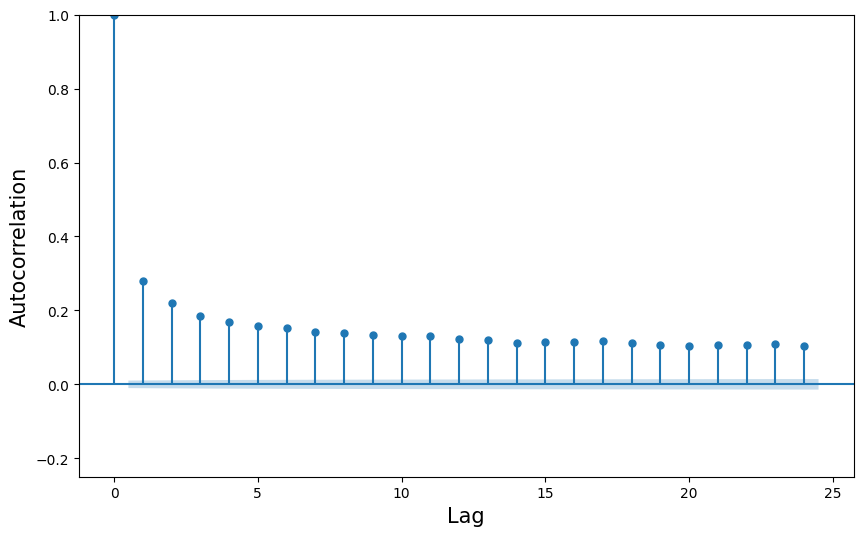

In [116]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [117]:
acf_hist, confint_hist = acf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [118]:
import scipy.stats as stats
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9992255739642725, pvalue=1.1604530212175938e-09)

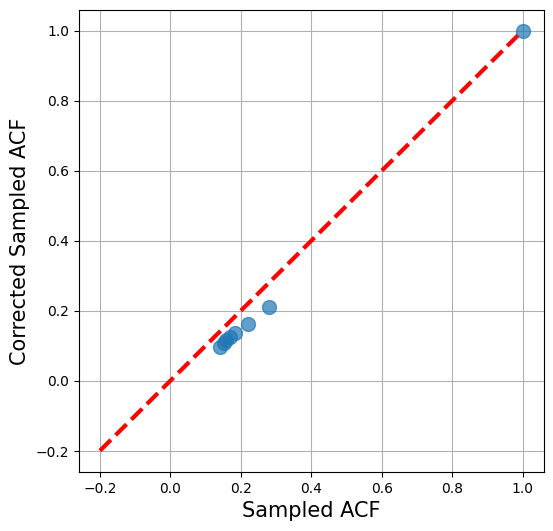

In [119]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

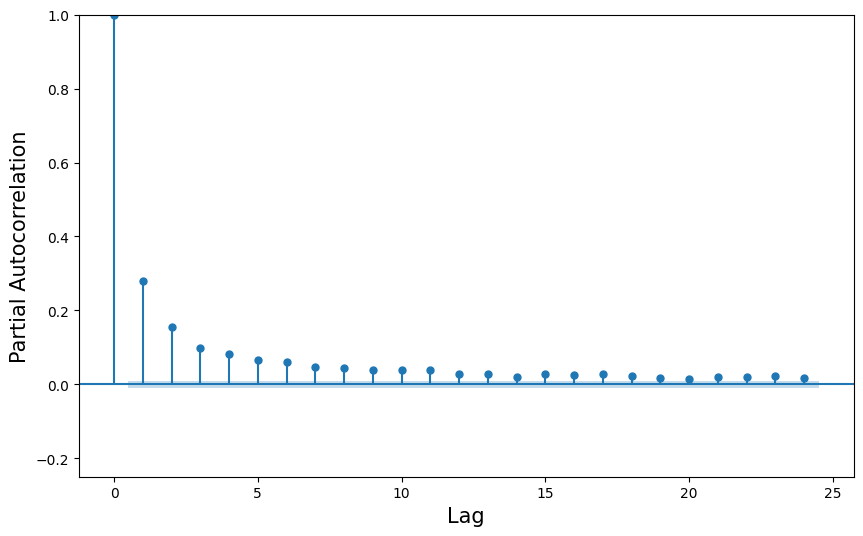

In [120]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [121]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [122]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9977158214870503, pvalue=2.9743072662053267e-08)

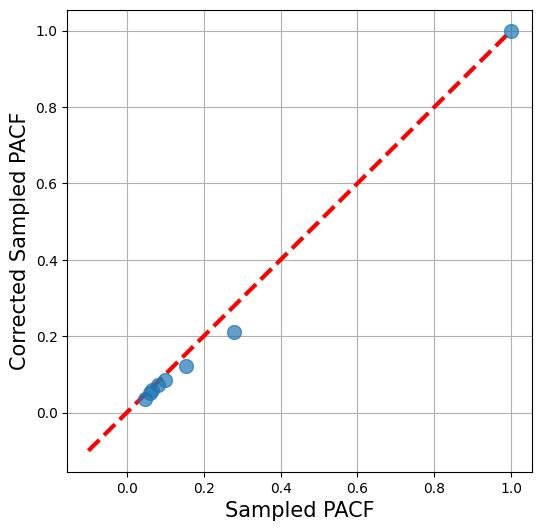

In [123]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs_REVERSED/Hs_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

QQ-plot between quantiles 0.05 and 0.95 of the whole distribution

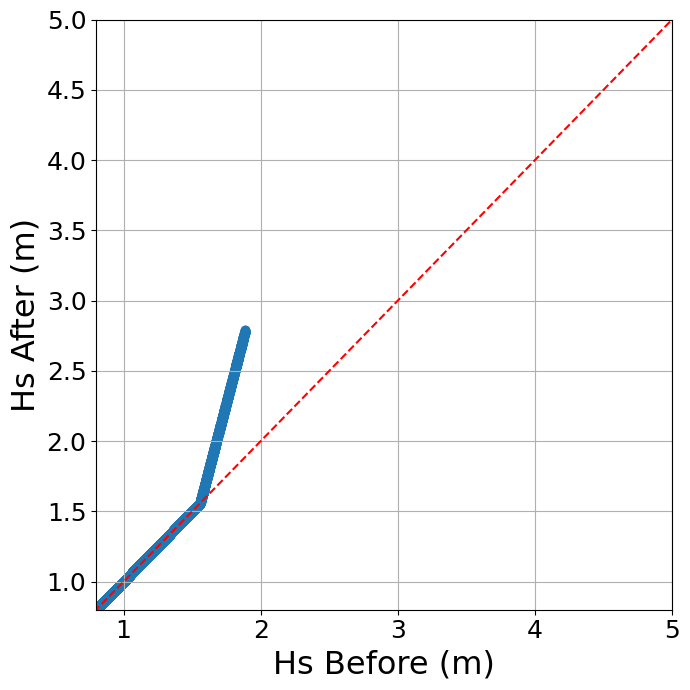

In [124]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete.n_sim_pit + 1)) / (extr_corr_complete.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,5], [0,5], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Hs Before (m)", fontsize=23)
ax1.set_ylabel("Hs After (m)", fontsize=23)
ax1.grid()
ax1.set_xlim(0.8, 5)
ax1.set_ylim(0.8, 5)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete.folder}/Hs_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

In [125]:
extr_corr_complete.quantile_to_correct

0.9

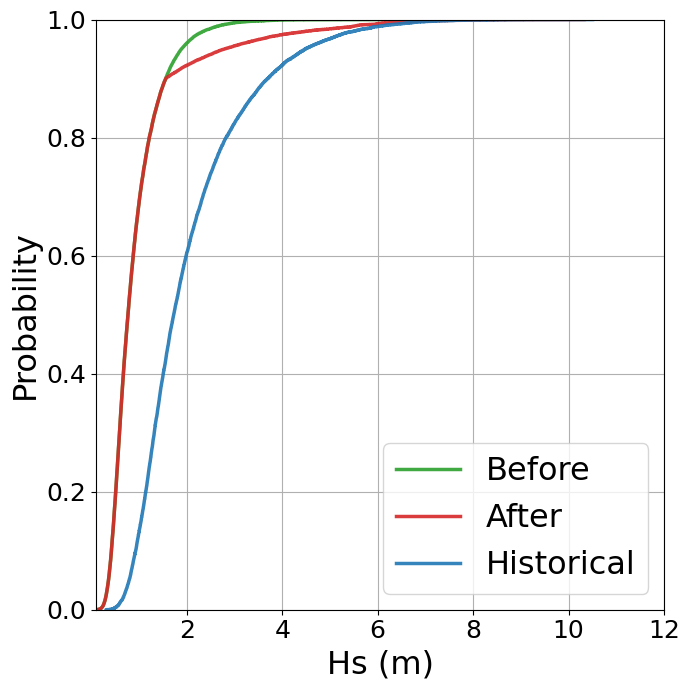

In [126]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# ECDF
ax1.ecdf(extr_corr_complete.sim_pit_data_sorted, label="Before", alpha=0.9, linewidth=2.5, color = "tab:green")
ax1.ecdf(extr_corr_complete.sim_pit_data_corrected, label="After", alpha=0.9, linewidth=2.5, color = "tab:red")
# Historical ECDF
ax1.ecdf(extr_corr_complete.pit_data_sorted, label="Historical", alpha=0.9, linewidth=2.5, color = "tab:blue")
# Adjusted CDF
# x_vals = np.linspace(0, max(max(extr_corr_complete.sim_pit_data_sorted), max(extr_corr_complete.sim_pit_data_corrected)), 100)
# ax1.plot(
#     x_vals, 
#     genextreme.cdf(
#         x_vals, 
#         c=-extr_corr_complete.parameters[2], 
#         loc=extr_corr_complete.parameters[0], 
#         scale=extr_corr_complete.parameters[1]
#     ), 
#     label="Adjusted CDF", 
#     color="black", 
#     linestyle='dashed'
# )
ax1.set_xlim(extr_corr_complete.opt_threshold, 12)
ax1.set_xlim(0.1, 12)
ax1.set_ylim(0.0,1)
ax1.set_xlabel("Hs (m)", fontsize=23)
ax1.set_ylabel("Probability", fontsize=23)
ax1.grid()
ax1.legend(loc="lower right", fontsize=23)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete.folder}/Hs_ECDF.png", dpi=300, bbox_inches='tight')
plt.show()
# plt.close(fig)

# Tp

In [127]:
config_tp = {
    'var': "Tp",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/Santona/Hs_Santona_Tp'
}

pot_config_tp = {
    'n0': 10,
    'min_peak_distance': 2,
    # 'init_threshold': 0.0,
    'init_threshold': np.quantile(df_hist["Tp"], 0.98),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete_tp = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config_tp,
    pot_config=pot_config_tp,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 7.634083262873939


In [128]:
extr_corr_complete_tp.opt_threshold

16.08078956604004

In [129]:
ecdf_hist_tp = ECDF(df_hist["Tp"])
ecdf_hist_tp(extr_corr_complete_tp.opt_threshold)

0.9800136892539356

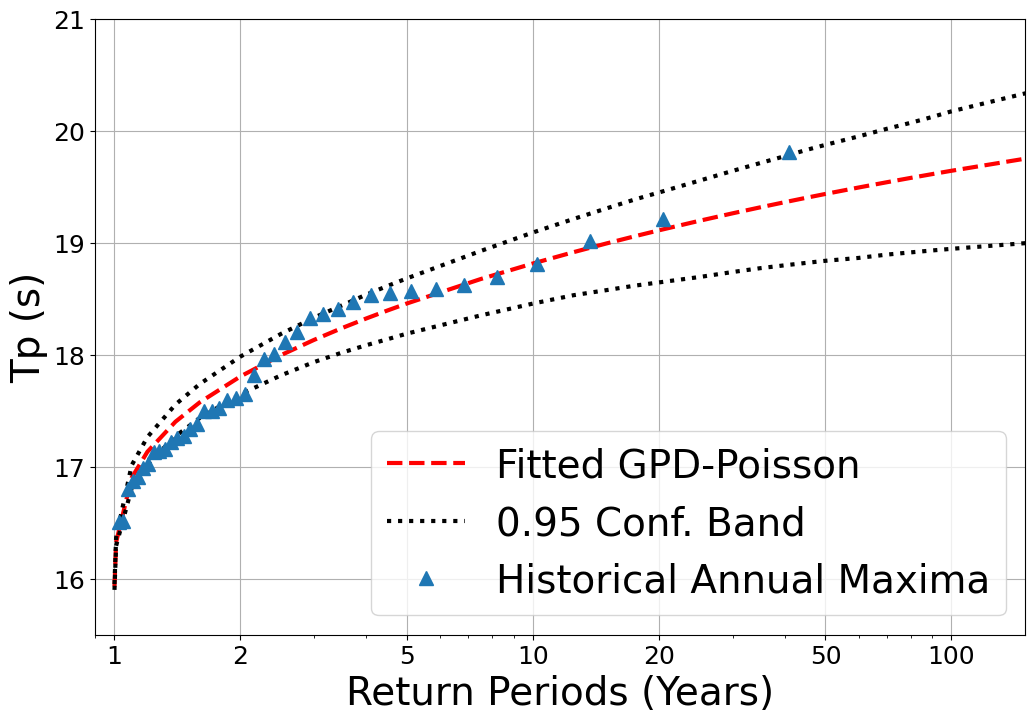

In [130]:
extr_corr_complete_tp.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete_tp.return_period_plot()
ax.set_ylim(15.5, 21)
ax.set_xlim(0.9,150)
ax.set_ylabel("Tp (s)", fontsize=28)
ax.set_xlabel("Return Periods (Years)", fontsize=28)
ax.legend(loc = "lower right", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

Threshold diagnostics

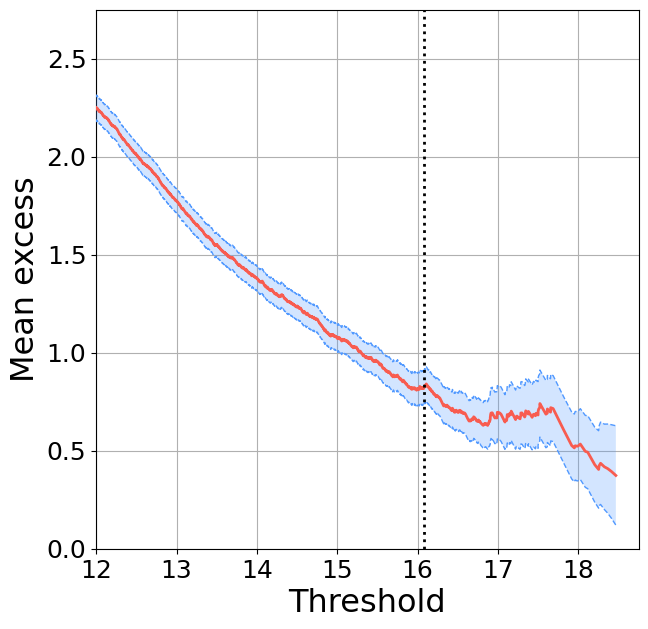

In [131]:
from scipy.stats import norm

mrlp_threshold = 0.0 
# mrlp_threshold = extr_corr_complete_tp.opt_threshold

(
    pks_unicos_valid,
    excedencias_mean_valid,
    excedencias_weight_valid,
    pks,
    locs,
    autocorrelations,
) = pot_fun(df_hist["Tp"], mrlp_threshold)



# if conf_level is not None:
interlow, interup = norm.interval(
    0.95,
    loc=excedencias_mean_valid,
    scale=np.sqrt(1 / excedencias_weight_valid),
)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.grid(False)

# Plotting central estimates of mean re sidual life
ax.plot(
    pks_unicos_valid,
    excedencias_mean_valid,
    color="#F85C50",
    lw=2,
    ls="-",
    zorder=15,
)

# if conf_level is not None:
ax.plot(pks_unicos_valid, interlow, color="#5199FF", lw=1, ls="--", zorder=10)
ax.plot(pks_unicos_valid, interup, color="#5199FF", lw=1, ls="--", zorder=10)

ax.fill_between(
    pks_unicos_valid,
    interlow,
    interup,
    facecolor="#5199FF",
    edgecolor="None",
    alpha=0.25,
    zorder=5,
)

ax.vlines(extr_corr_complete_tp.opt_threshold, ymin=0, ymax=excedencias_mean_valid.max()*1.1, colors="k", linestyles="dotted", lw=2, label="Optimal threshold", zorder=20)
ax.set_ylim(0, 2.75)
ax.set_xlim(12, 18.75)
ax.set_xlabel("Threshold", fontsize=23)
ax.set_ylabel("Mean excess", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_MRLP.png", dpi=300, bbox_inches="tight")
plt.show()

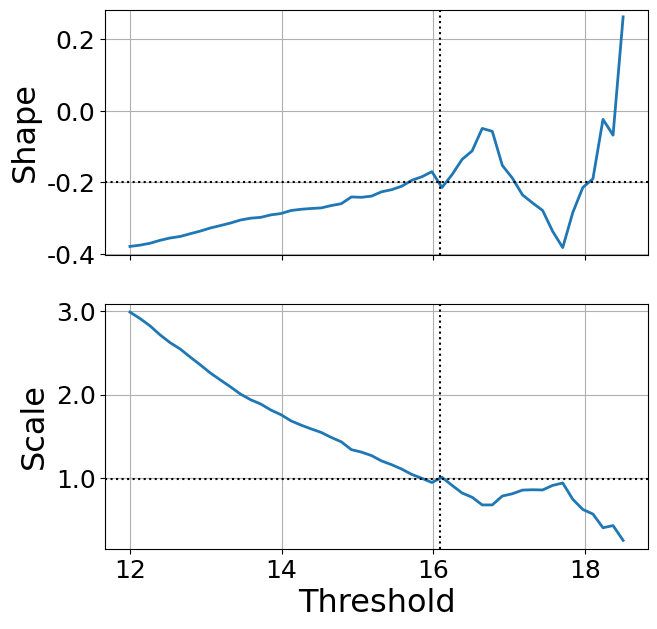

In [132]:
from scipy.stats import genpareto
thresholds = np.linspace(12, 18.5, 50)
shape_stab = []
scale_stab = []
for threshold in thresholds:
    pot, pot_sorted, locs = extr_corr_complete_tp.obtain_pots(
        df_hist["Tp"], 
        n0=10, 
        min_peak_distance=2, 
        threshold=threshold,
        optimize_threshold=False
    )
    
    shape, _, scale = genpareto.fit(pot, floc=threshold)
    shape_stab.append(shape)
    scale_stab.append(scale)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(211)
ax1.plot(thresholds, shape_stab, lw=2)
ax1.vlines(extr_corr_complete_tp.opt_threshold, ymin=min(shape_stab)-0.02, ymax=max(shape_stab)+0.02, color="k", ls="dotted", lw=1.5)
# ax1.set_xlabel("Threshold")
ax1.set_ylabel("Shape", fontsize=23)
ax1.axhline(y=extr_corr_complete_tp.parameters[2], color="k", ls="dotted", lw=1.5)
ax1.grid()
ax1.set_ylim(min(shape_stab)-0.02, max(shape_stab)+0.02)
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

ax2 = fig.add_subplot(212)
ax2.plot(thresholds, scale_stab, lw=2)
ax2.vlines(extr_corr_complete_tp.opt_threshold, ymin=min(scale_stab)-0.1, ymax=max(scale_stab)+0.1, color="k", ls="dotted", lw=1.5)
ax2.set_xlabel("Threshold", fontsize=23)
ax2.set_ylabel("Scale", fontsize=23)
ax2.axhline(y=extr_corr_complete_tp.parameters[1], color="k", ls="dotted", lw=1.5)
ax2.grid()
ax2.set_ylim(min(scale_stab)-0.1, max(scale_stab)+0.1)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='minor', labelsize=18)
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_StabPlots.png", dpi=300, bbox_inches="tight")

plt.show()


In [133]:
extr_corr_complete_tp.test_dist()

{'Statistic': 32.35421407029732, 'P-value': 2.5030074679577297e-09}

In [134]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete_tp.parameters
mu = u + sigma/xi * (extr_corr_complete_tp.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete_tp.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete_tp.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete_tp.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete_tp.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

KeyboardInterrupt: 

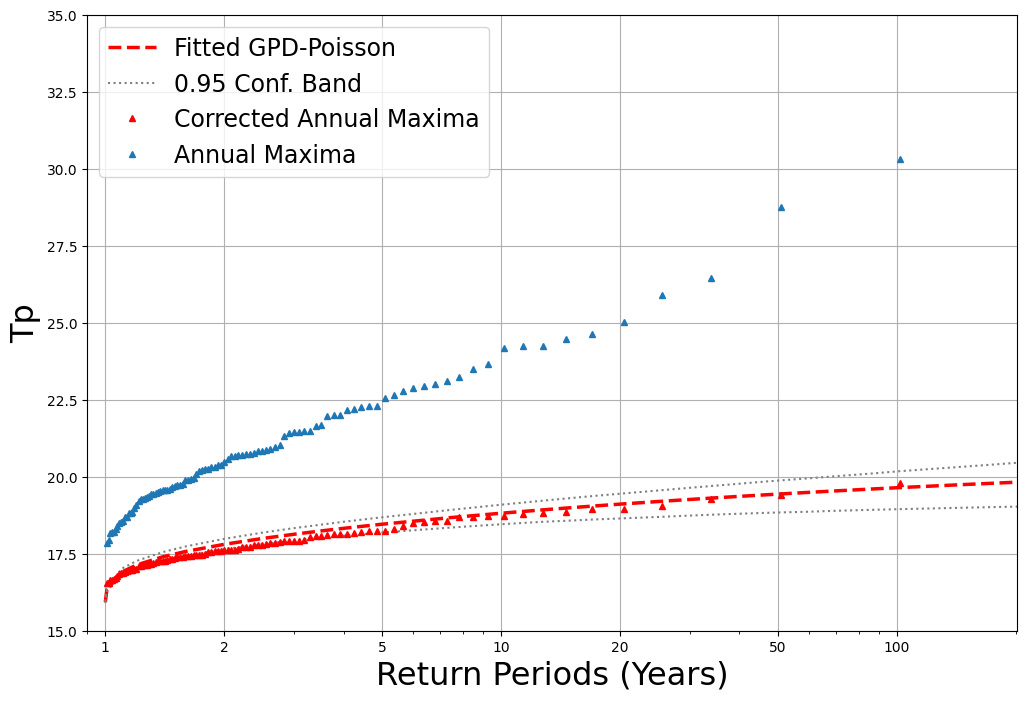

In [ ]:
quantile_to_correct_tp = 0.9
extr_corr_complete_tp.apply_sim_correction(quantile_to_correct=quantile_to_correct_tp)
fig, ax = extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(15, 35)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
extr_corr_complete_tp.parameters

[16.08078956604004, 0.9865893559228269, -0.19947040645308553]

In [ ]:
extr_corr_complete_tp.poiss_parameter, extr_corr_complete_tp.sim_poiss_parameter

(5.949869678302533, 13.583952941176472)

In [ ]:
extr_corr_complete_tp.sim_poiss_parameter/ extr_corr_complete_tp.poiss_parameter

2.2830673066190426

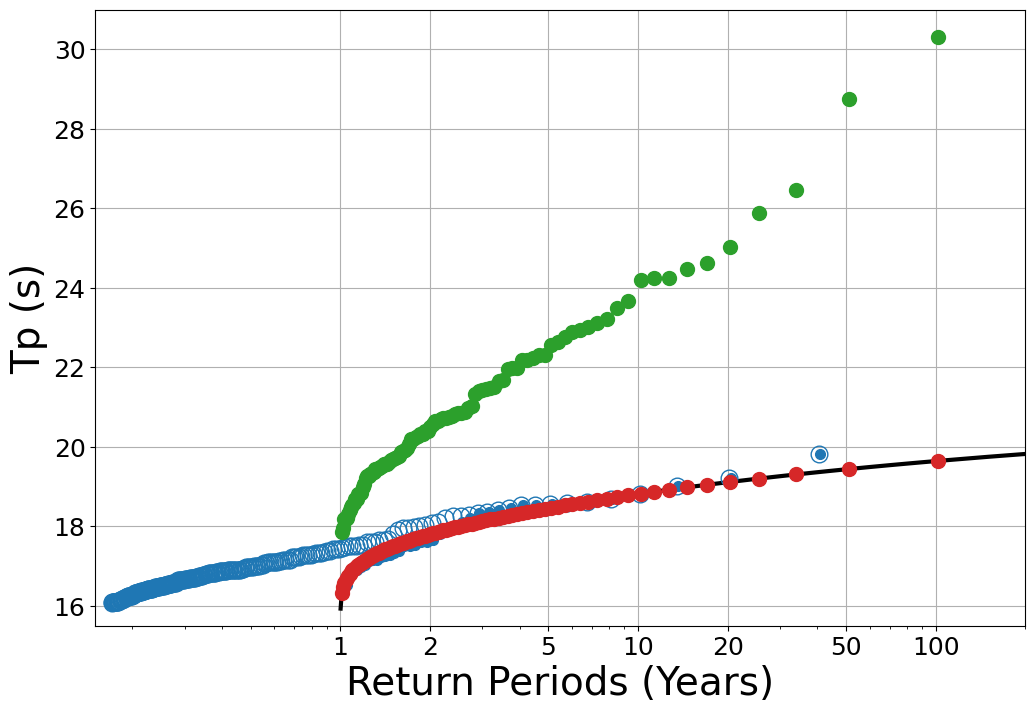

In [ ]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, np.sort(extr_corr_complete_tp.x_vals_gpd_poiss_hist), color = 'black', linewidth=3, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=7, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete_tp.n_pot + 1) / (extr_corr_complete_tp.n_pot + 1))) / (extr_corr_complete_tp.n_pot / (extr_corr_complete_tp.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete_tp.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=12, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted[extr_corr_complete_tp.am_index_0:], color="tab:green", linewidth=0, marker='o',markersize=10, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete_tp.n_pot_sim + 1) / (extr_corr_complete_tp.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete_tp.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete_tp.n_sim_year_peaks - extr_corr_complete_tp.am_index_0)
ecdf_max_probs_sim = np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1 - extr_corr_complete_tp.am_index_0) / (extr_corr_complete_tp.n_sim_year_peaks + 1 - extr_corr_complete_tp.am_index_0)   # ECDF
sim_max_data_corrected = q_pot(ecdf_max_probs_sim[extr_corr_complete_tp.am_index_0:], extr_corr_complete_tp.parameters, extr_corr_complete_tp.poiss_parameter)    # Corrected POT
if extr_corr_complete_tp.n_sim_year_peaks > 1:
    # sim_aux_pit_corrected = np.interp(
    #                 extr_corr_complete_tp.sim_pit_data,              # x-coords to interpolate
    #                 np.append(min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted),    # x-coords of data points
    #                 np.append(min(extr_corr_complete_tp.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
    #             )
    sim_aux_pit_corrected = np.interp(
                extr_corr_complete_tp.sim_pit_data,              # x-coords to interpolate
                np.append([min(extr_corr_complete_tp.sim_pit_data), np.quantile(extr_corr_complete_tp.sim_pit_data, extr_corr_complete_tp.quantile_to_correct)], extr_corr_complete_tp.sim_max_data_sorted[extr_corr_complete_tp.am_index_0:]),    # x-coords of data points
                np.append([min(extr_corr_complete_tp.sim_pit_data), np.quantile(extr_corr_complete_tp.sim_pit_data, extr_corr_complete_tp.quantile_to_correct)], sim_max_data_corrected)  # y-coords of data points 
            )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_pit_data_corrected[extr_corr_complete_tp.sim_max_idx])

ax.semilogx(extr_corr_complete_tp.T_annmax_sim, sim_max_data_corrected_sorted, color = 'tab:red',linewidth=0, marker='o',markersize=10,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=28)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=28)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.15, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=15.5, top=31)
# ax.legend(loc='upper left', fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()
# ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")

plt.show()

## Loop over correction

In [ ]:
dict_maximos_corregidos_Tp = {}
dict_sim_pit_corrected_Tp = {}
for i in range(100):
    
    extr_corr_complete_tp.apply_sim_correction(random_state=i, quantile_to_correct=quantile_to_correct_tp)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    dict_maximos_corregidos_Tp[i] = np.sort(extr_corr_complete_tp.sim_pit_data_corrected[extr_corr_complete_tp.sim_max_idx])
    dict_sim_pit_corrected_Tp[i] = extr_corr_complete_tp.sim_pit_data_corrected

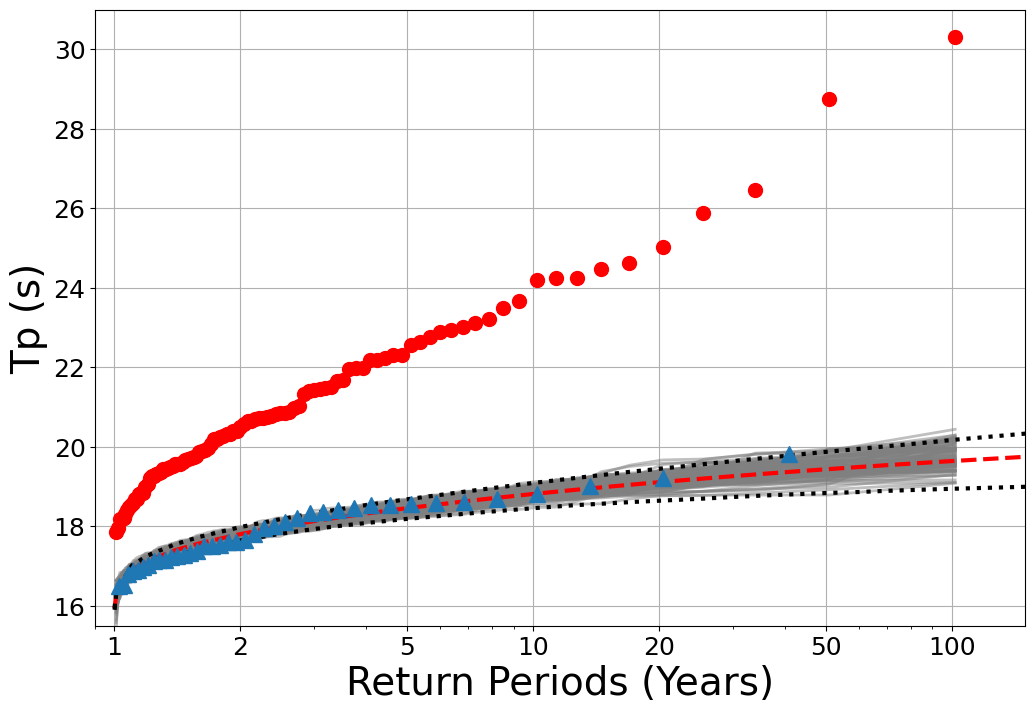

In [ ]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.x_vals_gpd_poiss_hist, color = 'red',linestyle='dashed', linewidth=3, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=3, label=f'{extr_corr_complete_tp.conf} Conf. Band')
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=3)


ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=10, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=12, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=28)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=28)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=15.5, top=31)
# ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# leg = ax.legend(loc='best', ncol=1, fontsize=23)
# for lh in leg.legend_handles:
#     lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
extr_corr_complete_tp.correlation()

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9939828707081482}

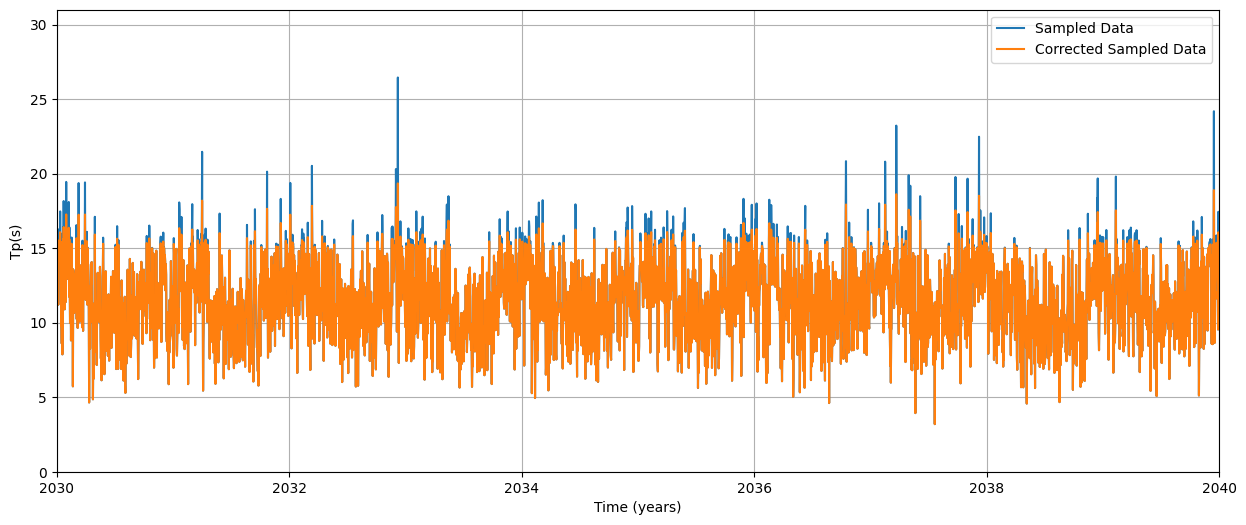

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data, label="Sampled Data")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data_corrected, label="Corrected Sampled Data")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 31)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Tp(s)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change between simulations

In [ ]:
sim_poiss_param_100_tp = np.zeros(100)
for i in range(100):
    sim_pot_corrected_tp, _, _ = extr_corr_complete_tp.obtain_pots(
                dict_sim_pit_corrected_Tp[i],
                threshold=extr_corr_complete_tp.opt_threshold,
                n0 = extr_corr_complete_tp.pot_config['n0'],
                min_peak_distance=extr_corr_complete_tp.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete_tp.pot_config['siglevel'],
                plot_flag = extr_corr_complete_tp.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_tp[i] = sim_pot_corrected_tp.size / extr_corr_complete_tp.time_interval_sim

In [ ]:
print(np.median(sim_poiss_param_100_tp), np.mean(sim_poiss_param_100_tp), np.std(sim_poiss_param_100_tp))

5.059329411764706 5.252197781512605 1.2326625584004225


In [ ]:
extr_corr_complete_tp.sim_poiss_parameter

13.583952941176472

In [ ]:
extr_corr_complete_tp.poiss_parameter

5.949869678302533

In [ ]:
np.quantile(sim_poiss_param_100_tp, [0.025, 0.975])

array([3.51479832, 7.84245563])

In [ ]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_tp >= poiss_hist_lb) & (sim_poiss_param_100_tp <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

37.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [ ]:
wald_lb = extr_corr_complete_tp.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)
wald_ub = extr_corr_complete_tp.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)

In [ ]:
poiss_hist_lb, poiss_hist_ub

(4.1681705726683775, 5.555718493555108)

In [ ]:
wald_lb, wald_ub

(5.193951052997872, 6.705788303607194)

In [ ]:
print(f"{np.mean((sim_poiss_param_100_tp >= wald_lb) & (sim_poiss_param_100_tp <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

32.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [ ]:
bloques = {}
for j in range(extr_corr_complete_tp.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= min(extr_corr_complete_tp.sim_pit_data)) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (min(extr_corr_complete_tp.sim_pit_data_corrected), extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= extr_corr_complete_tp.sim_max_data_sorted[j-1]) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (extr_corr_complete_tp.sim_max_data_sorted[j-1], extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (np.sort(extr_corr_complete_tp.sim_pit_data_corrected[extr_corr_complete_tp.sim_max_idx])[j-1], np.sort(extr_corr_complete_tp.sim_pit_data_corrected[extr_corr_complete_tp.sim_max_idx])[j])
            # (extr_corr_complete.sim_max_data_corrected_sorted[j-1], extr_corr_complete.sim_max_data_corrected_sorted[j])
            )

In [ ]:
bloques

{0: (36484,
  (2.3518926411971, 17.850811503524792),
  (2.3518926411971, 16.244153136403483)),
 1: (41,
  (17.850811503524792, 17.956235225790262),
  (16.244153136403483, 16.25191546538311)),
 2: (63,
  (17.956235225790262, 18.175428787397607),
  (16.25191546538311, 16.42399862907222)),
 3: (3,
  (18.175428787397607, 18.19710327573736),
  (16.42399862907222, 16.587853973062813)),
 4: (4,
  (18.19710327573736, 18.220296343180422),
  (16.587853973062813, 16.662952380270813)),
 5: (16,
  (18.220296343180422, 18.311216434209072),
  (16.662952380270813, 16.694022177496734)),
 6: (16,
  (18.311216434209072, 18.40768419150487),
  (16.694022177496734, 16.70718543418822)),
 7: (13,
  (18.40768419150487, 18.48547739319836),
  (16.70718543418822, 16.84792070330698)),
 8: (8,
  (18.48547739319836, 18.538906402633486),
  (16.84792070330698, 16.853903576935384)),
 9: (4,
  (18.538906402633486, 18.577365591007776),
  (16.853903576935384, 16.910921078420493)),
 10: (21,
  (18.577365591007776, 18.68692

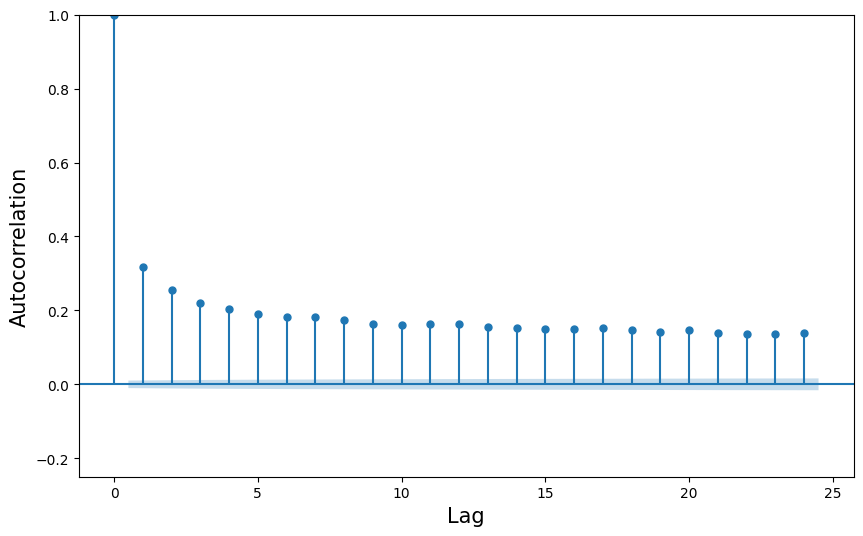

In [ ]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
acf_hist, confint_hist = acf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [ ]:
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999679269182522, pvalue=8.24805665354731e-14)

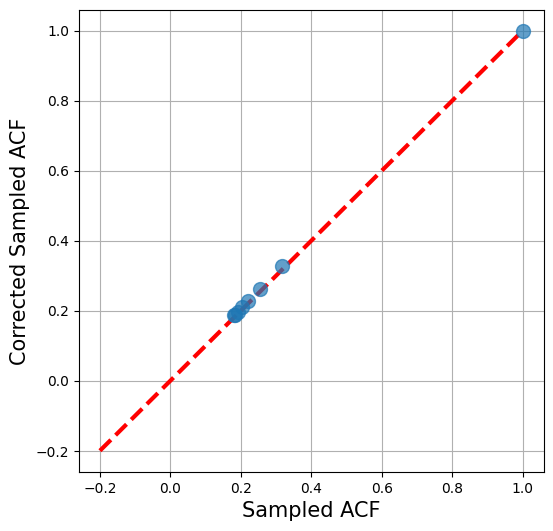

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

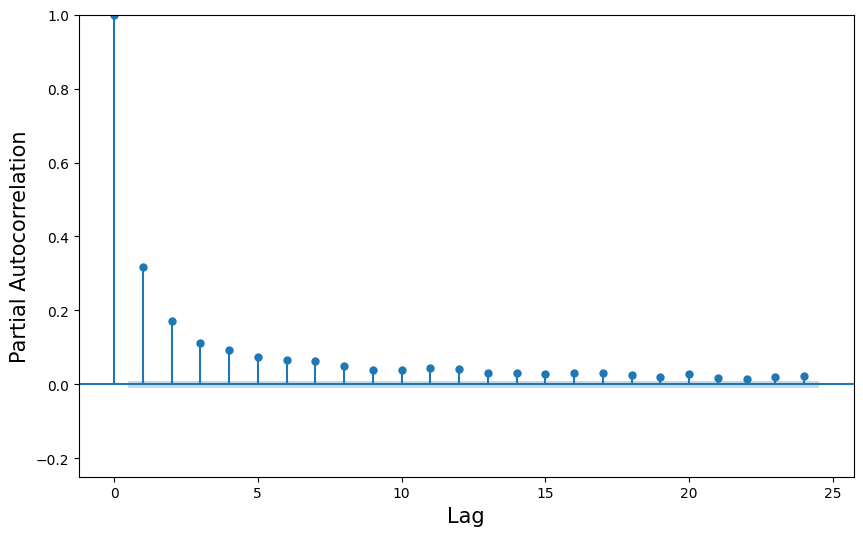

In [ ]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [ ]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9999407609318433, pvalue=5.196912062496749e-13)

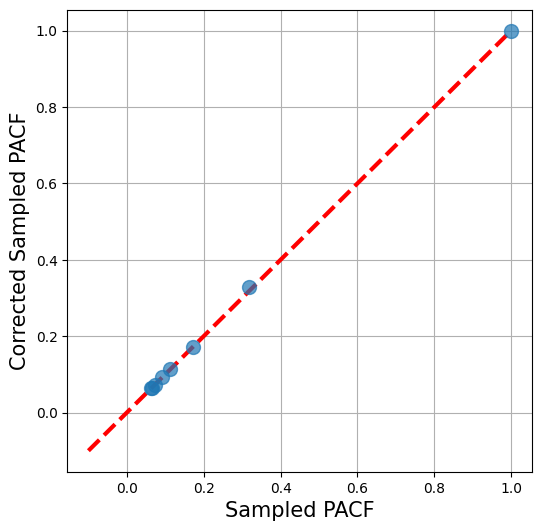

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

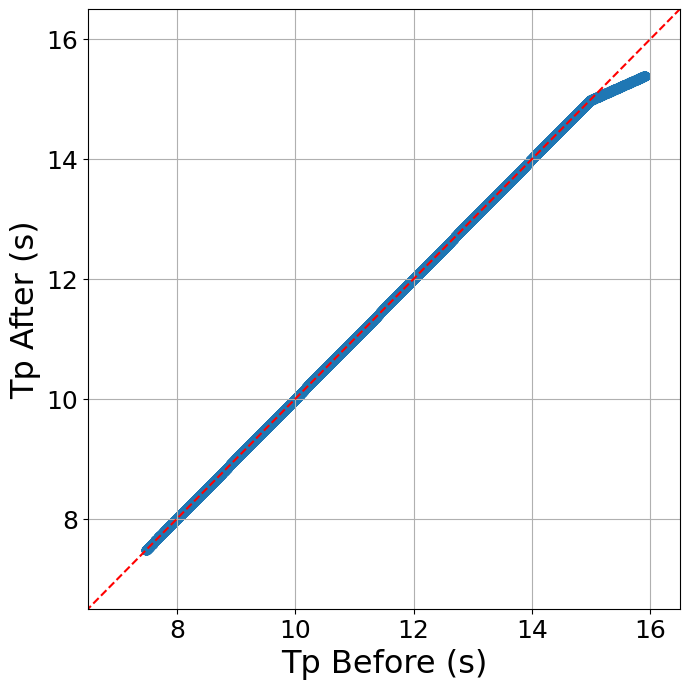

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete_tp.n_sim_pit + 1)) / (extr_corr_complete_tp.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete_tp.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete_tp.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,20], [0,20], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Tp Before (s)", fontsize=23)
ax1.set_ylabel("Tp After (s)", fontsize=23)
ax1.grid()
ax1.set_xlim(6.5, 16.5)
ax1.set_ylim(6.5, 16.5)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete_tp.folder}/Tp_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

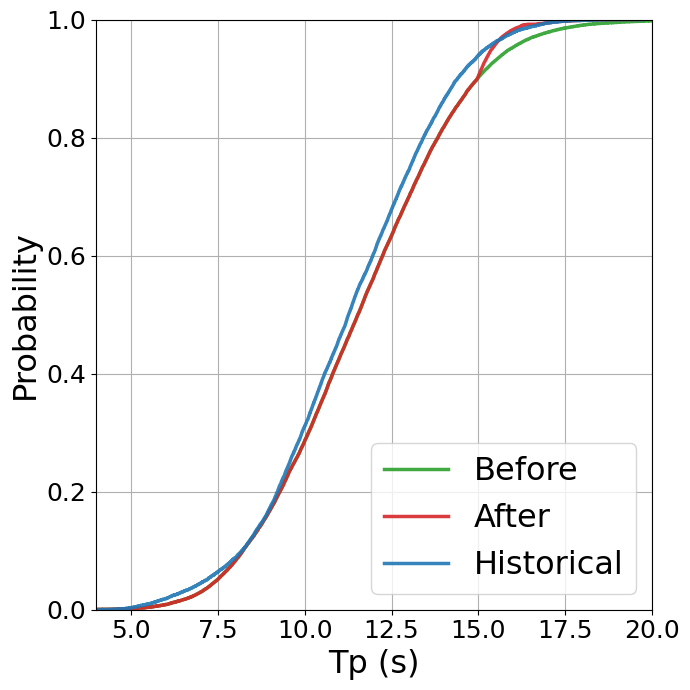

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# ECDF
ax1.ecdf(extr_corr_complete_tp.sim_pit_data_sorted, label="Before", alpha=0.9, linewidth=2.5, color = "tab:green")
ax1.ecdf(extr_corr_complete_tp.sim_pit_data_corrected, label="After", alpha=0.9, linewidth=2.5, color = "tab:red")
# Historical ECDF
ax1.ecdf(extr_corr_complete_tp.pit_data_sorted, label="Historical", alpha=0.9, linewidth=2.5, color = "tab:blue")

# ax1.set_xlim(extr_corr_complete_tp.opt_threshold, 12)
ax1.set_xlim(4, 20)
ax1.set_ylim(0.0,1)
ax1.set_xlabel("Tp (s)", fontsize=23)
ax1.set_ylabel("Probability", fontsize=23)
ax1.grid()
ax1.legend(loc="lower right", fontsize=23)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete_tp.folder}/Tp_ECDF.png", dpi=300, bbox_inches='tight')
plt.show()
# plt.close(fig)

# Correlation between series

In [98]:
spear_corr_before= stats.spearmanr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
spear_corr_after = stats.spearmanr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
kendall_corr_before= stats.kendalltau(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
kendall_corr_after= stats.kendalltau(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
pearson_corr_before= stats.pearsonr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
pearson_corr_after= stats.pearsonr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]

print(f"Spearman {spear_corr_before:.4f} -> {spear_corr_after:.4f}")
print(f"Kendall {kendall_corr_before:.4f} -> {kendall_corr_after:.4f}")
print(f"Pearson {pearson_corr_before:.4f} -> {pearson_corr_after:.4f}")

Spearman 0.5317 -> 0.5317
Kendall 0.3708 -> 0.3708
Pearson 0.5066 -> 0.5185


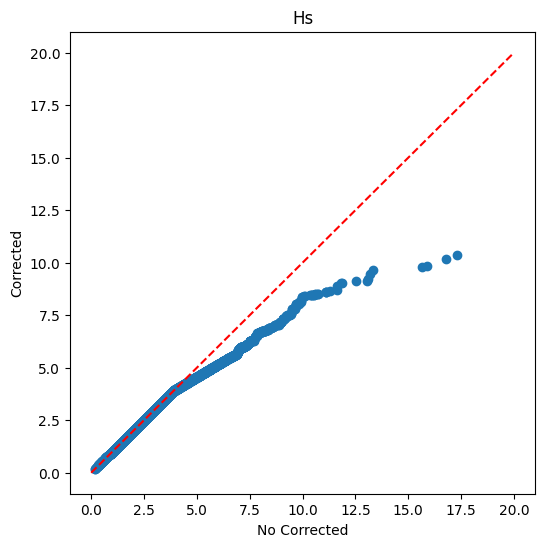

In [99]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete.sim_pit_data, extr_corr_complete.sim_pit_data_corrected)

ax.plot([0, 20], [0,20], "--r")
ax.set_title("Hs")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


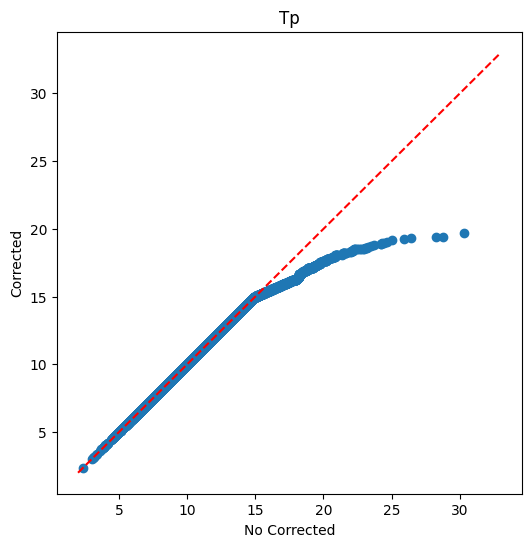

In [100]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete_tp.sim_pit_data, extr_corr_complete_tp.sim_pit_data_corrected)

ax.plot([2, 33], [2,33], "--r")
ax.set_title("Tp")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


Bivariate comparative

$$ 
\hat{\chi}_{H_s}(u)=\frac{\#\lbrace i: \hat{U}_i > u, \hat{V}_i > u \rbrace}{\#\lbrace i: \hat{U}_i > u\rbrace}, \quad u\in\lbrace 0.95, 0.97, 0.99\rbrace
$$

In [101]:
from statsmodels.distributions.empirical_distribution import ECDF

In [102]:
unified_threshold_095 = 0.95
unified_threshold_097 = 0.97
unified_threshold_099 = 0.99

ecdf_hs_before = ECDF(extr_corr_complete.sim_pit_data)
ecdf_hs_after = ECDF(extr_corr_complete.sim_pit_data_corrected)

ecdf_tp_before = ECDF(extr_corr_complete_tp.sim_pit_data)
ecdf_tp_after = ECDF(extr_corr_complete_tp.sim_pit_data_corrected)

xi_before_095 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_095) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_095)) / np.sum(ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_095)
xi_after_095 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_095) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_095)) / np.sum(ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_095)
print(f"Quantile {unified_threshold_095}: {xi_before_095:.4f}, {xi_after_095:.4f}")

xi_before_097 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_097) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_097)) / np.sum(ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_097)
xi_after_097 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_097) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_097)) / np.sum(ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_097)
print(f"Quantile {unified_threshold_097}: {xi_before_097:.4f}, {xi_after_097:.4f}")

xi_before_099 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_099) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_099)) / np.sum(ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_099)
xi_after_099 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_099) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_099)) / np.sum(ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_099)
print(f"Quantile {unified_threshold_099}: {xi_before_099:.4f}, {xi_after_099:.4f}")

Quantile 0.95: 0.2580, 0.2580
Quantile 0.97: 0.2159, 0.2159
Quantile 0.99: 0.0921, 0.0921


$$ 
\hat{\chi}_{T_p}(u)=\frac{\#\lbrace i: \hat{U}_i > u, \hat{V}_i > u \rbrace}{\#\lbrace i: \hat{V}_i > u\rbrace}, \quad u\in\lbrace 0.95, 0.97, 0.99\rbrace
$$

In [103]:
unified_threshold_095 = 0.95
unified_threshold_097 = 0.97
unified_threshold_099 = 0.99

xi_before_095 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_095) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_095)) / np.sum(ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_095)
xi_after_095 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_095) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_095)) / np.sum(ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_095)
print(f"Quantile {unified_threshold_095}: {xi_before_095:.4f}, {xi_after_095:.4f}")
xi_before_097 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_097) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_097)) / np.sum(ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_097)
xi_after_097 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_097) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_097)) / np.sum(ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_097)
print(f"Quantile {unified_threshold_097}: {xi_before_097:.4f}, {xi_after_097:.4f}")
xi_before_099 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold_099) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_099)) / np.sum(ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold_099)
xi_after_099 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold_099) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_099)) / np.sum(ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold_099)
print(f"Quantile {unified_threshold_099}: {xi_before_099:.4f}, {xi_after_099:.4f}")

Quantile 0.95: 0.2580, 0.2580
Quantile 0.97: 0.2159, 0.2159
Quantile 0.99: 0.0921, 0.0921


$$
\hat{C}(u,u) = \frac{1}{n}\sum_{i=1}^{n}\textbf{1}\lbrace \hat{U}_i \leq u, \hat{V}_i \leq u\rbrace, \quad \hat{\theta}(u) = \frac{\log{(\hat{C}(u,u))}}{\log{(u)}}.
$$

In [104]:
c_uu_before_095 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) <= unified_threshold_095) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) <= unified_threshold_095)) / extr_corr_complete.n_sim_pit
theta_before_095 = np.log(c_uu_before_095) / np.log(unified_threshold_095)

c_uu_after_095 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) <= unified_threshold_095) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) <= unified_threshold_095)) / extr_corr_complete.n_sim_pit
theta_after_095 = np.log(c_uu_after_095) / np.log(unified_threshold_095)

print(f"Quantile {unified_threshold_095}: {theta_before_095:.4f}, {theta_after_095:.4f}")

c_uu_before_097 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) <= unified_threshold_097) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) <= unified_threshold_097)) / extr_corr_complete.n_sim_pit
theta_before_097 = np.log(c_uu_before_097) / np.log(unified_threshold_097)

c_uu_after_097 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) <= unified_threshold_097) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) <= unified_threshold_097)) / extr_corr_complete.n_sim_pit
theta_after_097 = np.log(c_uu_after_097) / np.log(unified_threshold_097)

print(f"Quantile {unified_threshold_097}: {theta_before_097:.4f}, {theta_after_097:.4f}")

c_uu_before_099 = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) <= unified_threshold_099) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) <= unified_threshold_099)) / extr_corr_complete.n_sim_pit
theta_before_099 = np.log(c_uu_before_099) / np.log(unified_threshold_099)

c_uu_after_099 = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) <= unified_threshold_099) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) <= unified_threshold_099)) / extr_corr_complete.n_sim_pit
theta_after_099 = np.log(c_uu_after_099) / np.log(unified_threshold_099)

print(f"Quantile {unified_threshold_099}: {theta_before_099:.4f}, {theta_after_099:.4f}")

Quantile 0.95: 1.7771, 1.7771
Quantile 0.97: 1.8065, 1.8065
Quantile 0.99: 1.9172, 1.9172
